### Replicates the 3 state model case with Refactored Code

In [1]:
import numpy as np

In [2]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [3]:
import sys
sys.path.append('../')

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()

In [6]:
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma
print(gamma, validg)

1.664337575188073e-05 True


In [7]:
# Create initial State Vector Variables for the 3 state model assuming UF/OF transition (lean)
x0 = VariableVector(cAl2O3=2.5, uAl2O3=0.1, ACD= 2.9193)

In [8]:
# Create Input Vector Variables
u0 = VariableVector(I=126000.0, g=0.0, B=0.0)

In [9]:
# Create Measurement Vector Variables
z0 = VariableVector(Vcell=4.465858)

In [10]:
# Define the F matrix for 3 state model with first order dependency on dT
F = ControlMatrix(3, 3, 1)
# Identity matrix for the terms independent of dT
F.set_array_layer(0, np.identity(3, dtype=float))
# first order dependency on dT in layer 1
F.set_array_layer(1, np.array([[0.0, bbcell.kdiss, 0.0], [0.0, -bbcell.kdiss, 0.0], [0.0, 0.0, 0.0]]))

True

In [11]:
# demonstrate the F matrix evaluated with dT = 5 sec
F.array_eval(5)

array([[1.  , 0.01, 0.  ],
       [0.  , 0.99, 0.  ],
       [0.  , 0.  , 1.  ]])

In [12]:
# Define G with simple 3 terms, diagonal "dT"
G = ControlMatrix(3, 3, 1)
G.set_array_layer(0, np.zeros((3,3)))
G.set_array_layer(1, np.identity(3, dtype=float))

True

In [13]:
# demonstrate the G matrix evaluated with dT = 5 sec
G.array_eval(5)

array([[5., 0., 0.],
       [0., 5., 0.],
       [0., 0., 5.]])

In [14]:
# Define the B matrix for the 3 state, 3 input model with first order dependency on dT
B = ControlMatrix(3, 3, 1)
B.set_array_layer(0, np.array([[0.0, 100*(1-bbcell.r)/bbcell.m, 0.0], [0.0, 100*bbcell.r/bbcell.m, 0.0], [0.0, 0.0, 1.0]]))
B.set_array_layer(1, np.array([[-gamma/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [bbcell.alpha, 0.0, 0.0]]))

True

In [15]:
# demonstrate the B matrix evaluated with dT = 5 sec
B.array_eval(5)

array([[-4.62315993e-08,  2.22222222e-02,  0.00000000e+00],
       [ 0.00000000e+00,  3.33333333e-02,  0.00000000e+00],
       [-1.64690382e-10,  0.00000000e+00,  1.00000000e+00]])

In [16]:
# Define the noise standard deviations for simulation purposes (ie relatively low)
q1dstd = 0.0004    # alumina concentration variation
q1ustd = 0.0002    # undisolved alumina concentration variation
q2std = 0.0000001  # acd varation needs to be much lower
Q = ControlMatrix(3, 3, 0)
Q.set_array_layer(0, np.array([[q1dstd**2, 0.0, 0.0], [0.0, q1ustd**2, 0.0], [0.0, 0.0, q2std**2]]))
Q.array_display

array([[[1.6e-07, 0.0e+00, 0.0e+00],
        [0.0e+00, 4.0e-08, 0.0e+00],
        [0.0e+00, 0.0e+00, 1.0e-14]]])

In [17]:
# Define the measurement standard deviation
rstd = 0.001      # measurement variation (volts)
R = ControlMatrix(1, 1, 0)
R.set_array_layer(0, np.array([[rstd**2]]))
R.array_display

array([[[1.e-06]]])

In [18]:
from Refactor.UKFClass import DiscreteModel

In [19]:
# Define the 3 state model object instance for simulation
alumina3state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)
alumina3state.defined

True

In [20]:
# Import the UKF class and supporting functions
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack, ukf_execute

In [21]:
# Import the Sim class and supporting functions
from Refactor.SimClass import SimCell, plot_xsim, plot_usim, plot_zsim

In [22]:
# verify the actual shot mass for the cell
bbcell.shotMass.value

5.8

In [23]:
# now let us introduce a discrepancy between the shot mass set point and the actual
bbcell.shotSetPoint.value = 5.7
bbcell.calc_feed_cycle(126000)

(271.8084114214826, True)

In [24]:
# lets create an instance of the simulation class using the 3 state model
sim3state = SimCell(alumina3state, bbcell, 5, shotstd=0.1, Istd=25, statenoise=True)
sim3state.sim_valid

True

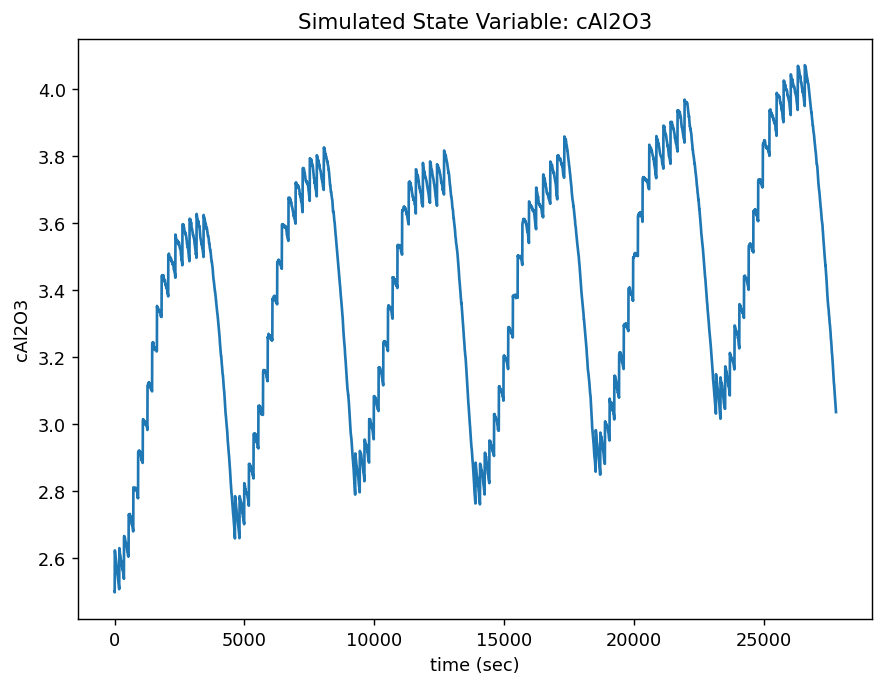

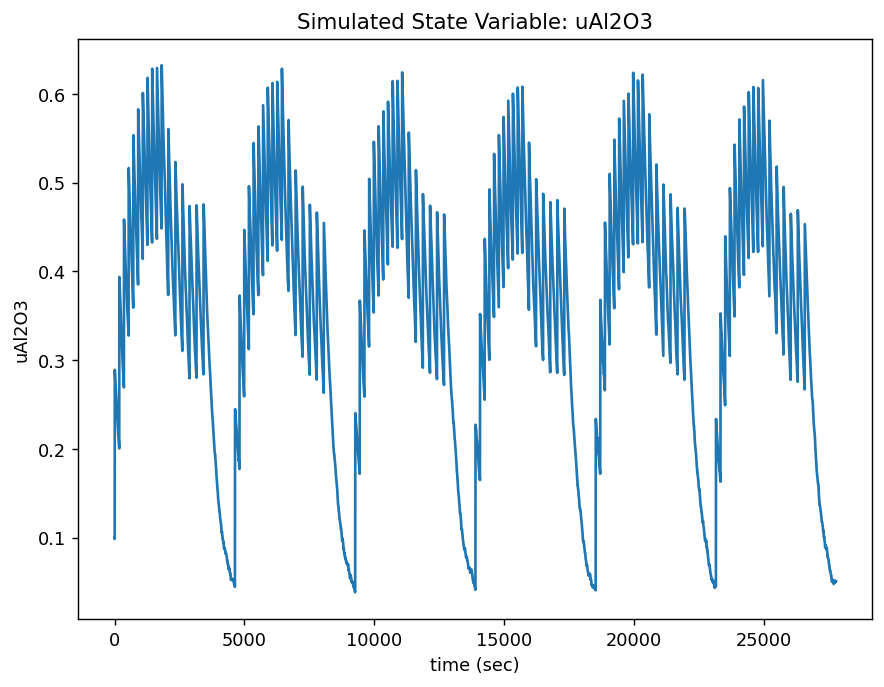

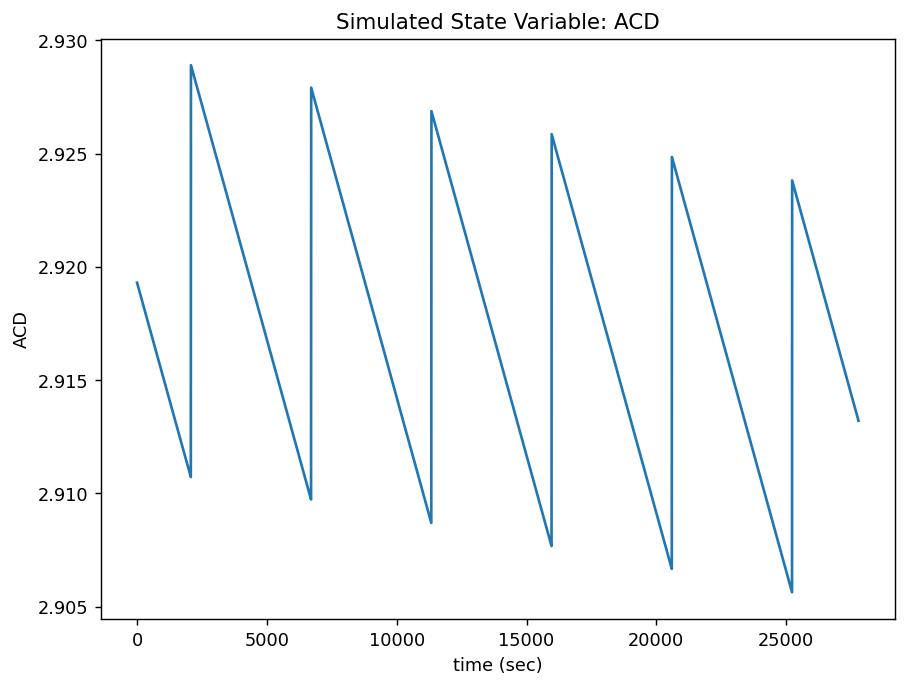

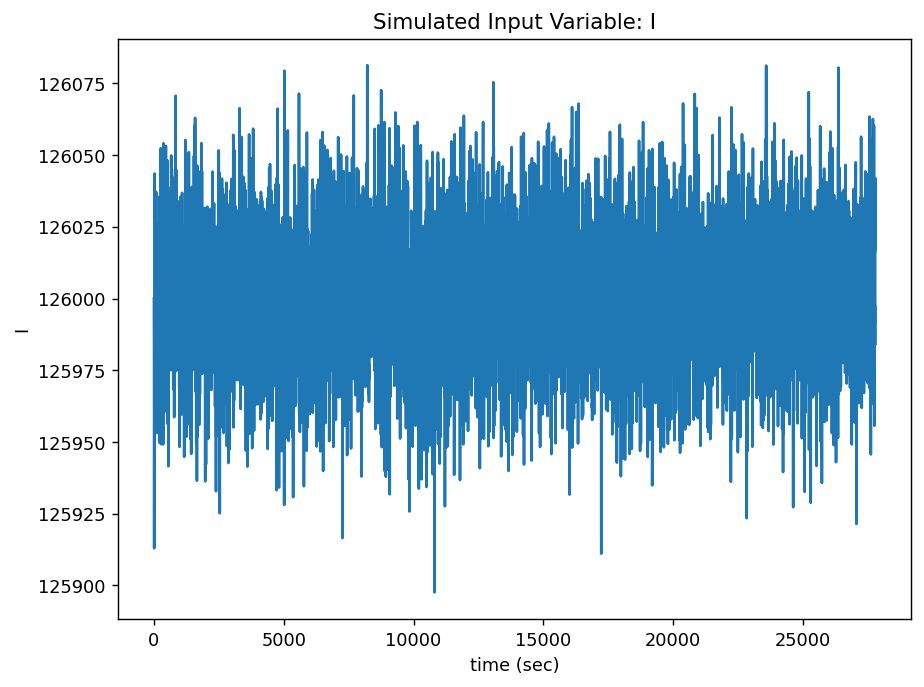

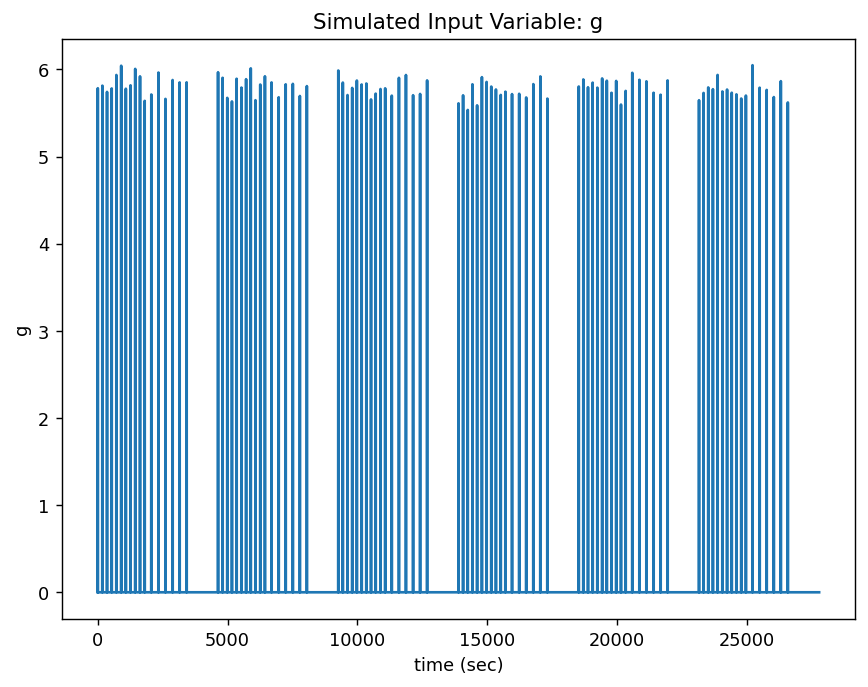

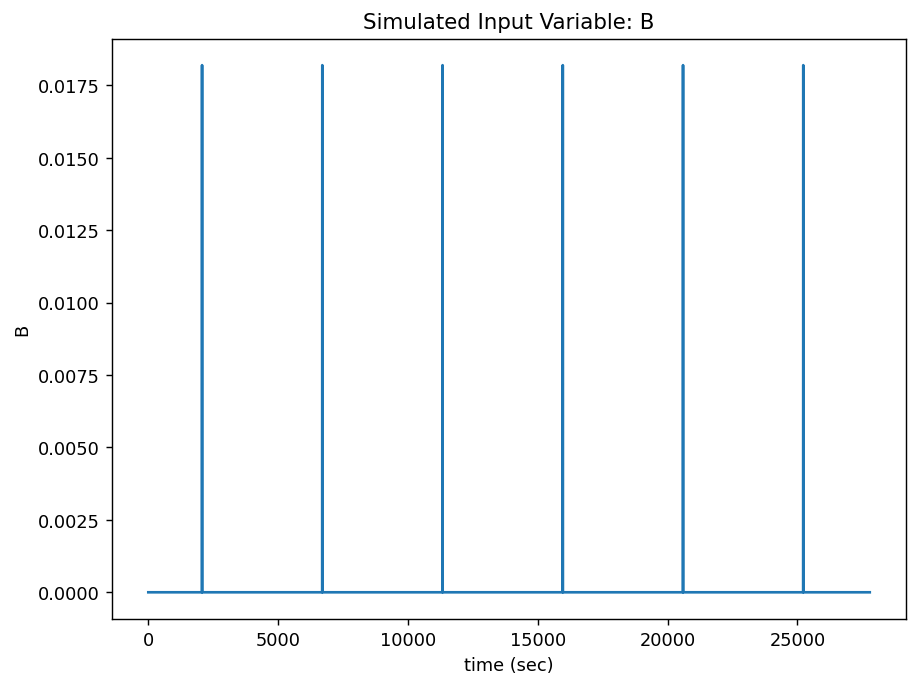

In [25]:
# Run a simulation at 5 sec dT and with 4 full adaptive feed cycles - 25kg OF, 20 min nominal and 20min UF (timed, not dependent on dR or dR/dt)
xtrue, utrue, unom = sim3state.sim_adaptfeedcycle(5, 25, 1.5, 1200, 1200, u0, x0, BeamMove=0.0182, plotresult=True, NumCycles=6)

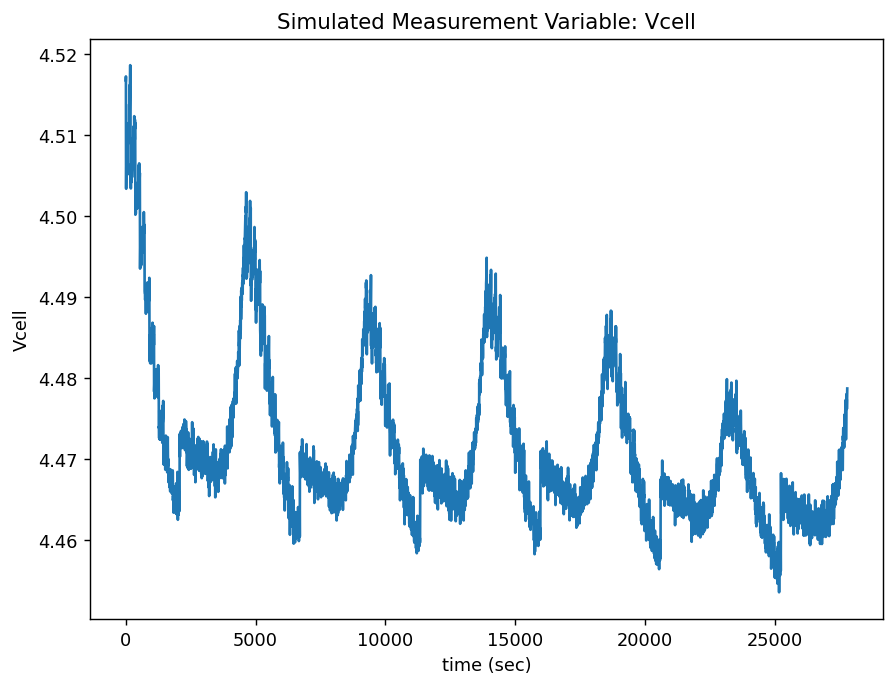

In [26]:
ztrue = sim3state.sim_observation(5, xtrue, utrue, plotresult=True)

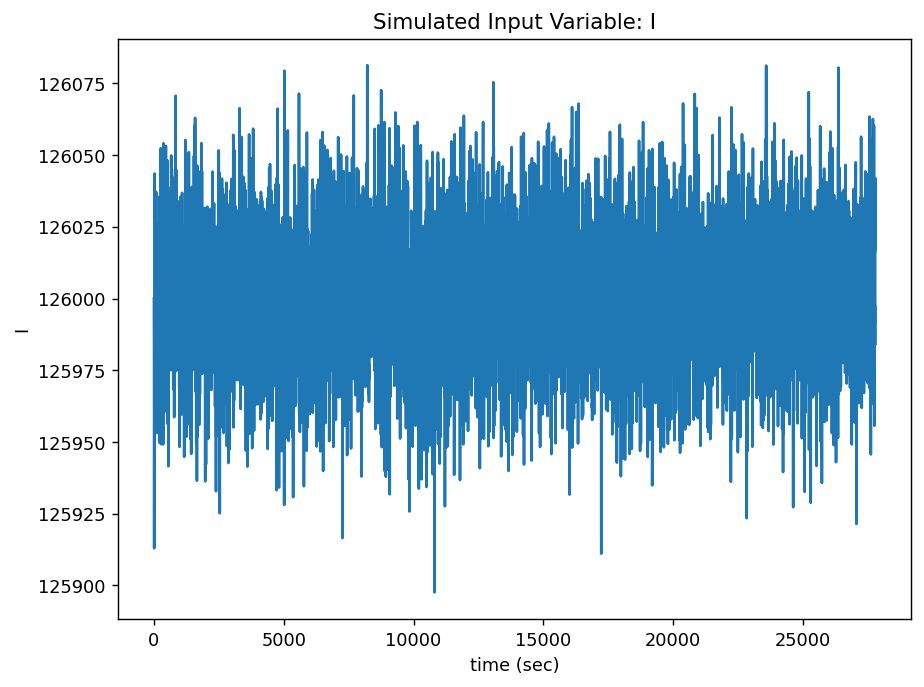

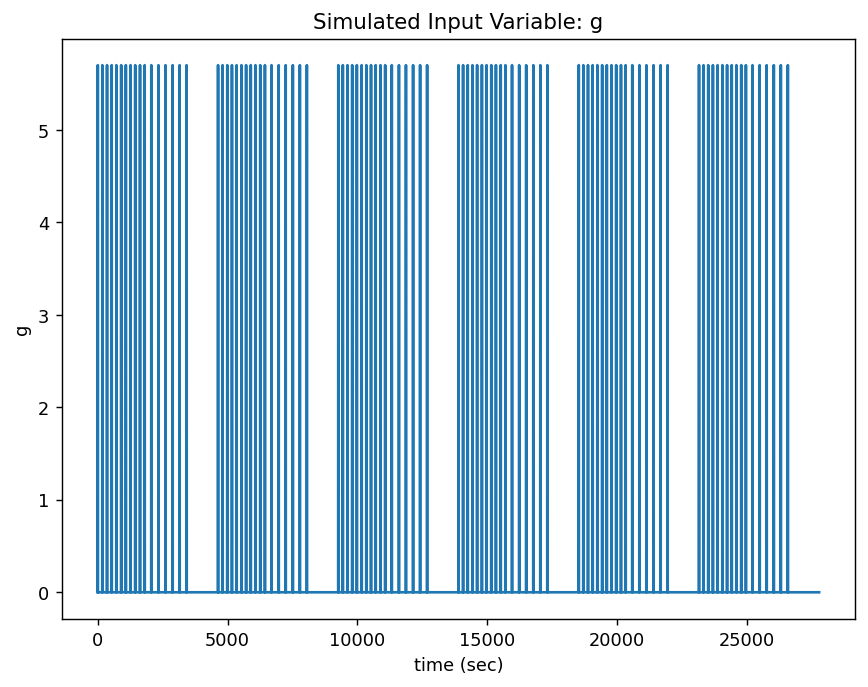

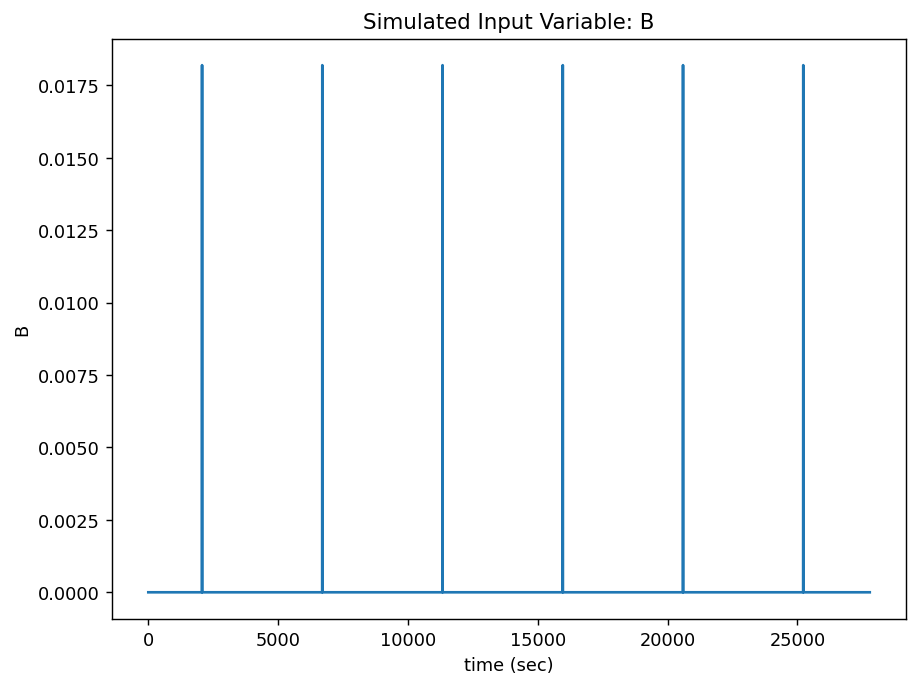

In [27]:
# plotting of the nominal feed input (not the simulated actual)
plot_usim(list(u0.dictionary.keys()), unom, 5)

In [28]:
# now need to repackage the simulation to suit the 4 state model. But first lets define the 4-state model

In [29]:
# Create initial State, Input and Measurement Vector Variables
x4s0 = VariableVector(cAl2O3=2.5, deltag_rate=0.00, ACD=2.9193, deltaI=0.0)
u4s0 = VariableVector(g0=0.0, B=0.0, I0=126000.0)
z4s0 = VariableVector(Vcell=4.465858, Icell=126000.0)

In [30]:
# Now need to define the 4 state model for use in the Kalman filter
# define the time constant forthe delta g rate model
# kdeltag = bbcell.kdiss
kdeltag = 0.002

In [31]:
# Define the F matrix for 4 state model with first order dependency on dT
F = ControlMatrix(4, 4, 1)
# Identity matrix for the terms independent of dT
F.set_array_layer(0, np.identity(4, dtype=float))
# first order dependency on dT in layer 1
F.set_array_layer(1, np.array([[0.0, 100/bbcell.m, 0.0, -gamma/bbcell.m],
                               [0.0, -kdeltag, 0.0, 0.0],
                               [0.0, 0.0, 0.0, bbcell.alpha],
                               [0.0, 0.0, 0.0, 0.0]]))

True

In [32]:
# evaluate F with dT = 5 sec
F.array_eval(5)

array([[ 1.00000000e+00,  2.77777778e-01,  0.00000000e+00,
        -4.62315993e-08],
       [ 0.00000000e+00,  9.90000000e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [33]:
# Simple noise model - dT terms on the diagonal
G = ControlMatrix(4, 4, 1)
G.set_array_layer(0, np.zeros((4,4)))
G.set_array_layer(1, np.identity(4, dtype=float))

True

In [34]:
# evaluate G with dT = 5 sec
G.array_eval(5)

array([[5., 0., 0., 0.],
       [0., 5., 0., 0.],
       [0., 0., 5., 0.],
       [0., 0., 0., 5.]])

In [35]:
# input control matrix for 4 states, 3 inputs so it is 4 x 3
B = ControlMatrix(4, 3, 1)
B.set_array_layer(0, np.array([[100/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]))
B.set_array_layer(1, np.array([[0.0, 0.0, -gamma/bbcell.m], [0.0, 0.0, 0.0], [0.0, 0.0, bbcell.alpha], [0.0, 0.0, 0.0]]))

True

In [36]:
# evaluate B with dT = 5 sec
B.array_eval(5)

array([[ 5.55555556e-02,  0.00000000e+00, -4.62315993e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [37]:
# Define the UKF noise standard deviations - Some tuning already applied relative to R - comments show original settings
q1std = 0.01         # 0.0002 alumina concentration variation (wt%)
q2std = 0.0005       # 0.0002 alumina feed mass discrepancy (kg/sec)
q3std = 0.000001       # 0.0000001 acd varation needs to be much lower (cm)
q4std = 30           # 30 deltaI varation is measured in (amps)
Q = ControlMatrix(4, 4, 0)
Q.set_array_layer(0, np.array([[q1std**2, 0.0, 0.0, 0.0],
                               [0.0, q2std**2, 0.0, 0.0],
                               [0.0, 0.0, q3std**2, 0.0],
                               [0.0, 0.0, 0.0, q4std**2]]))
Q.array_display

array([[[1.0e-04, 0.0e+00, 0.0e+00, 0.0e+00],
        [0.0e+00, 2.5e-07, 0.0e+00, 0.0e+00],
        [0.0e+00, 0.0e+00, 1.0e-12, 0.0e+00],
        [0.0e+00, 0.0e+00, 0.0e+00, 9.0e+02]]])

In [38]:
# Define the measurement standard deviations
r1std = 0.0010      # 0.001 measurement variation (volts)
r2std = 5           # 20 measurement variation (amps)
R = ControlMatrix(2, 2, 0)
R.set_array_layer(0, np.array([[r1std**2, 0.0], [0.0, r2std**2]]))
R.array_display

array([[[1.0e-06, 0.0e+00],
        [0.0e+00, 2.5e+01]]])

In [39]:
# initialise the 4 state model
alumina4state = DiscreteModel(F, B, G, Q, R, z4s0, u4s0, x4s0)
alumina4state.defined

True

In [40]:
# transform simualtion to the new model using the actual state and measuements but the nominal inputs
# from Refactor.Simulation import sim_transform
validtrfm, xsim, usim, zsim = sim3state.sim_transform(xtrue, unom, ztrue, 126000.0, 100, alumina4state)
validtrfm

True

In [41]:
# update the initial vector in the model to match the transformation
z4s0.setvector(zsim[0])
alumina4state.z0.setvector(zsim[0])
z4s0.vector

array([[4.51674214e+00],
       [1.26000000e+05]])

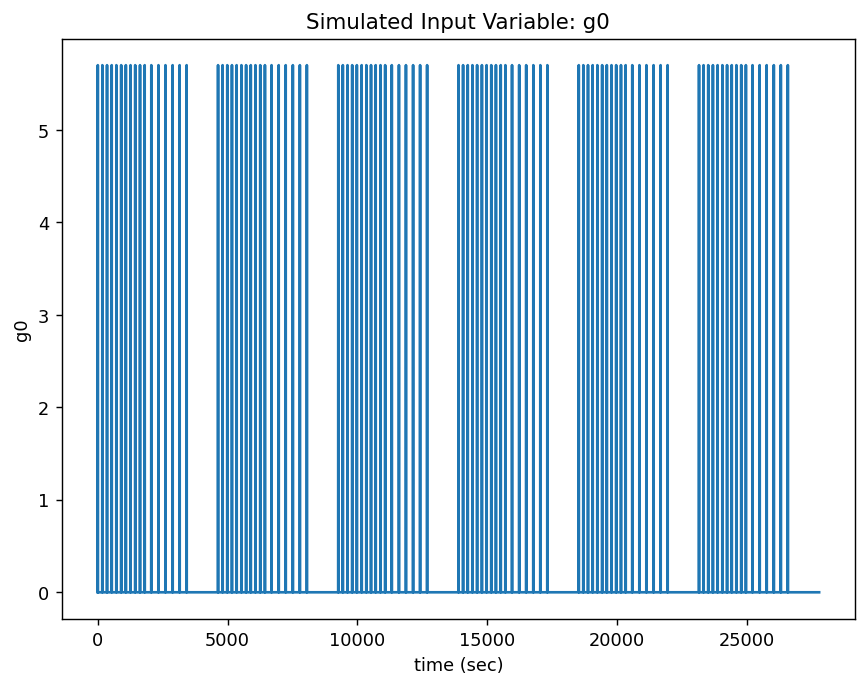

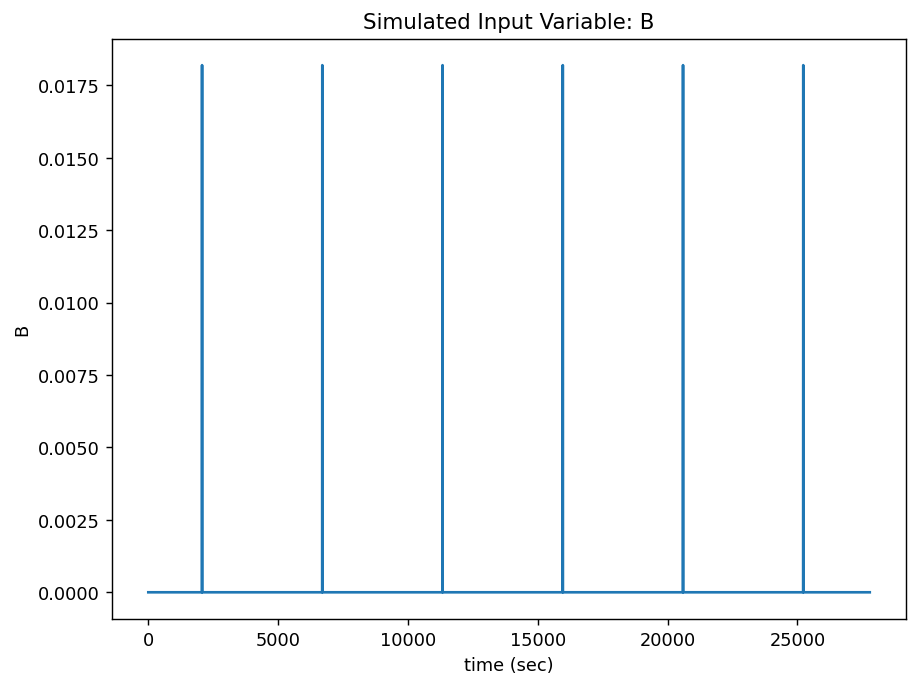

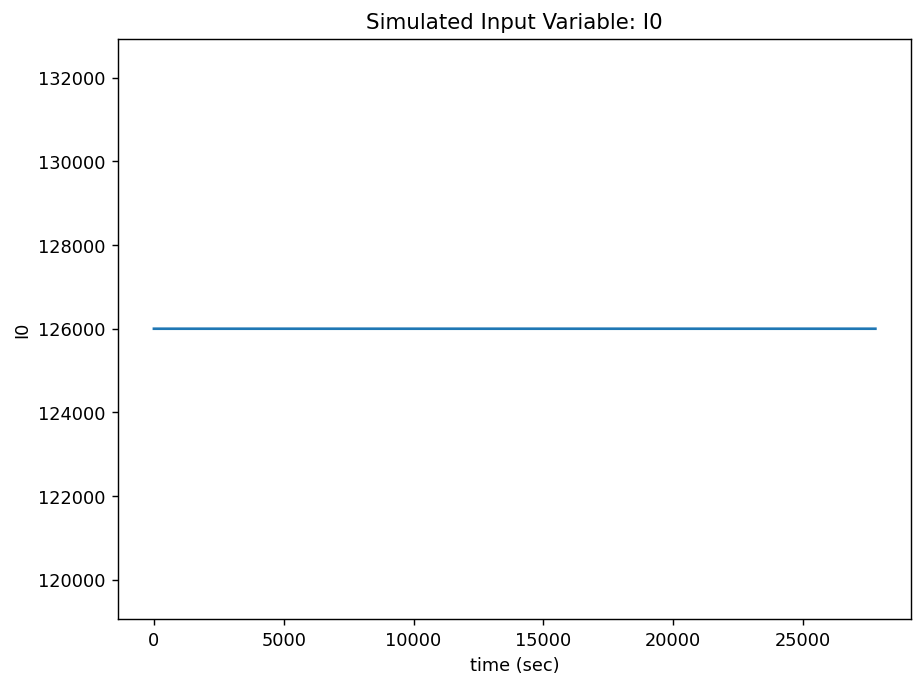

In [42]:
# plotting of the feed input as transformed - just to check all is good
plot_usim(list(u4s0.dictionary.keys()), usim, 5)

In [43]:
# Create an instance of the unscented Kalman Filter using the 4 state model
UKF4state = UKF(alumina4state, bbcell, x4s0, 5)
UKF4state.initialised

True

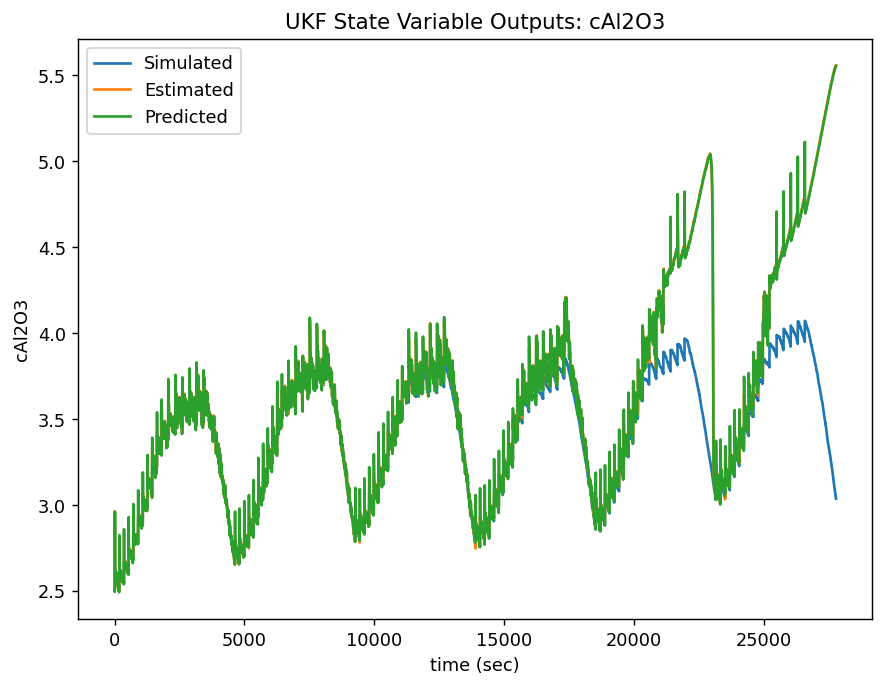

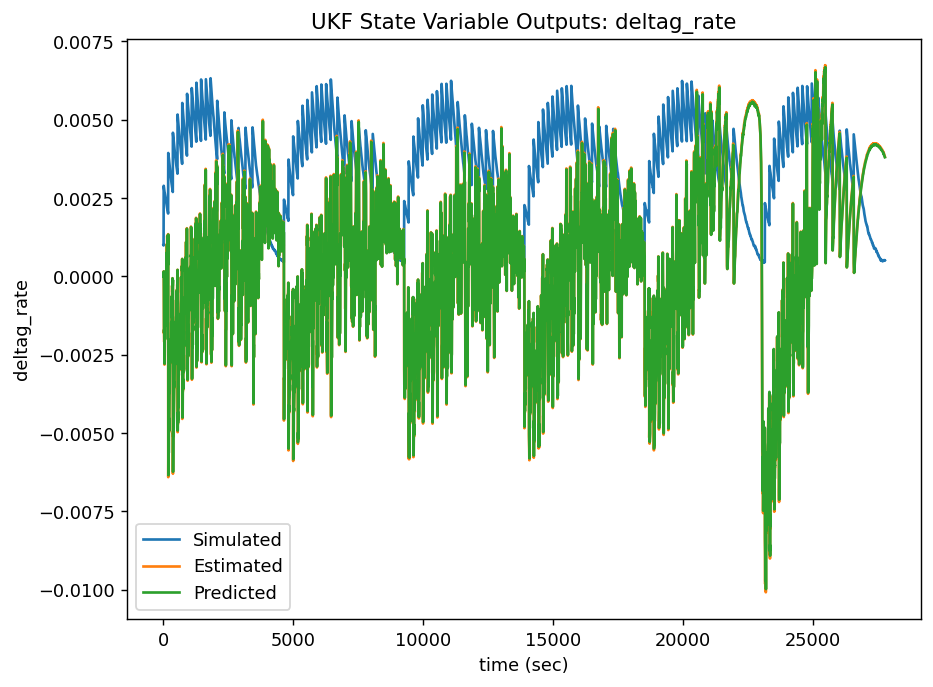

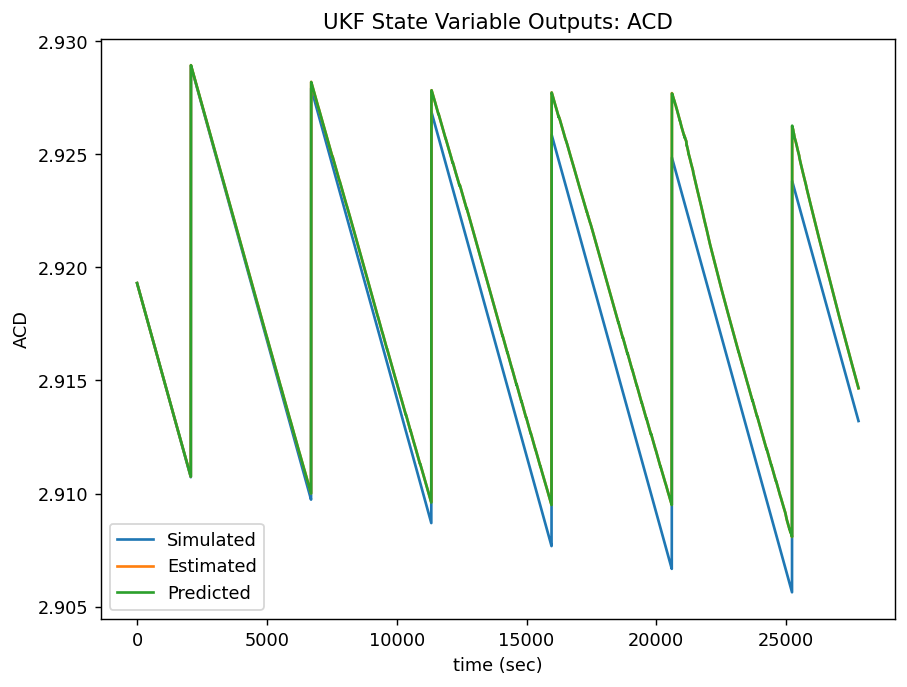

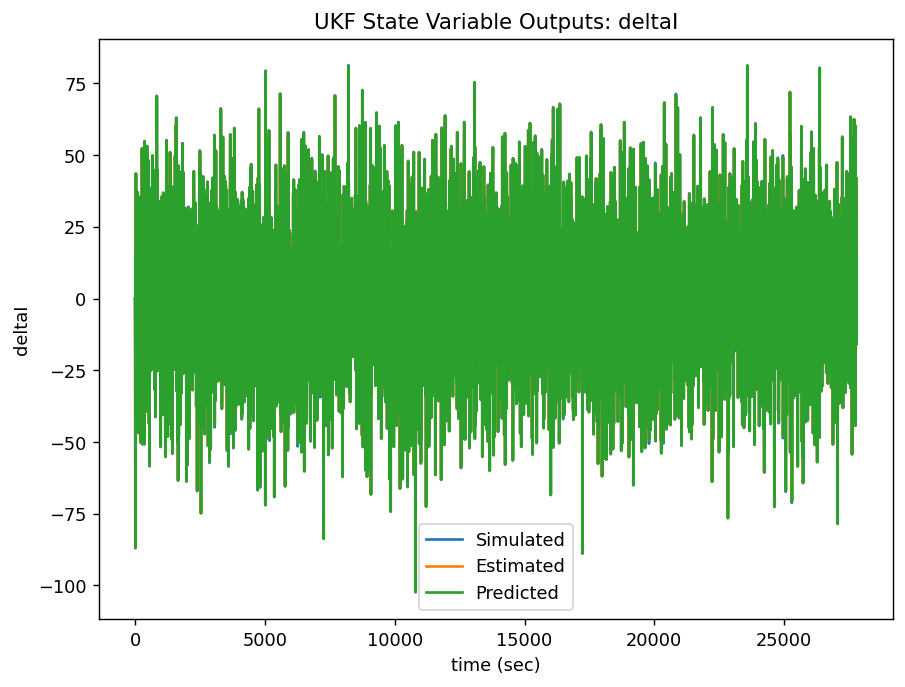

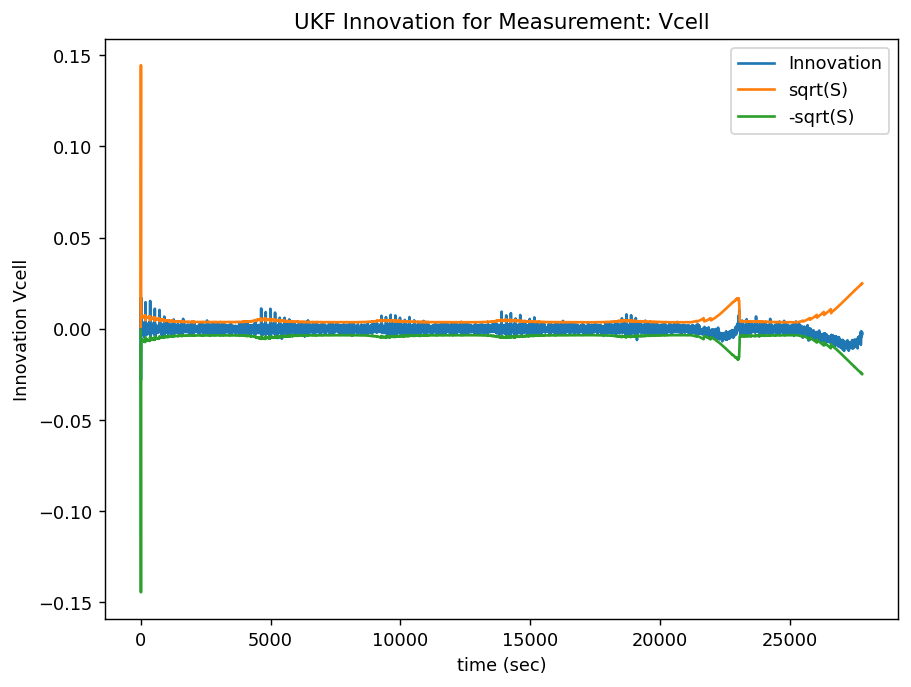

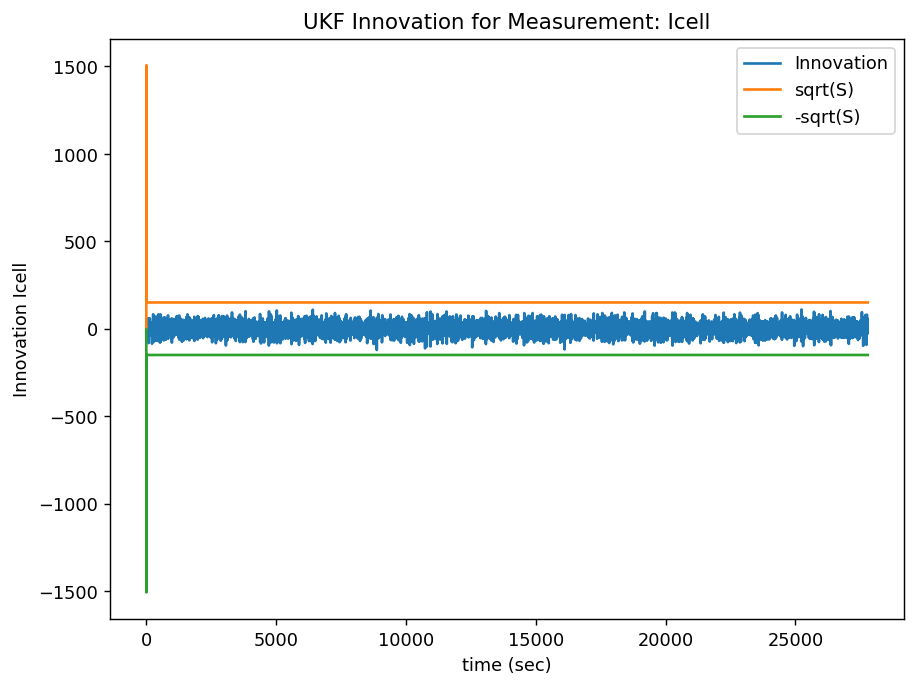

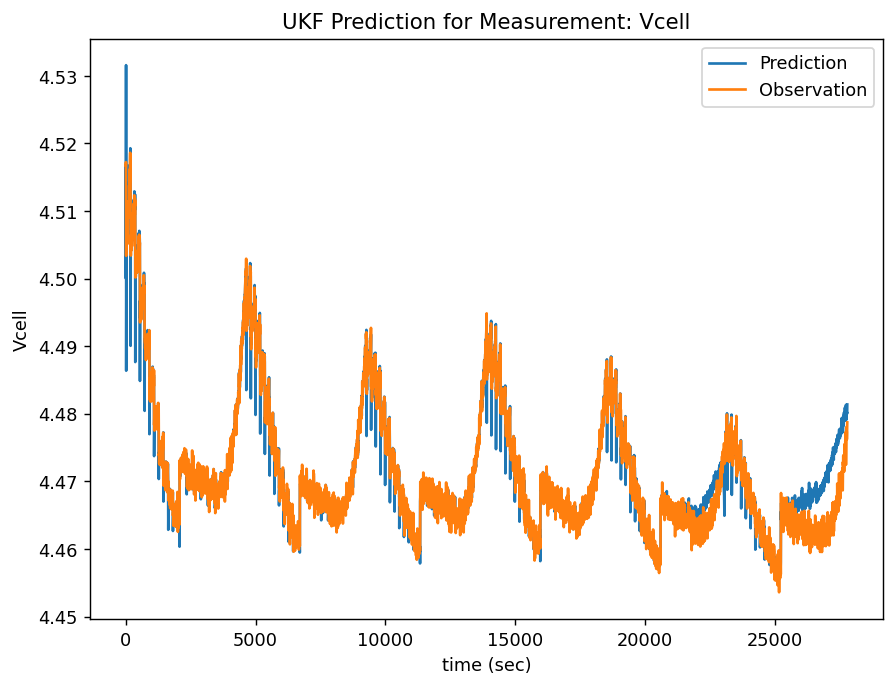

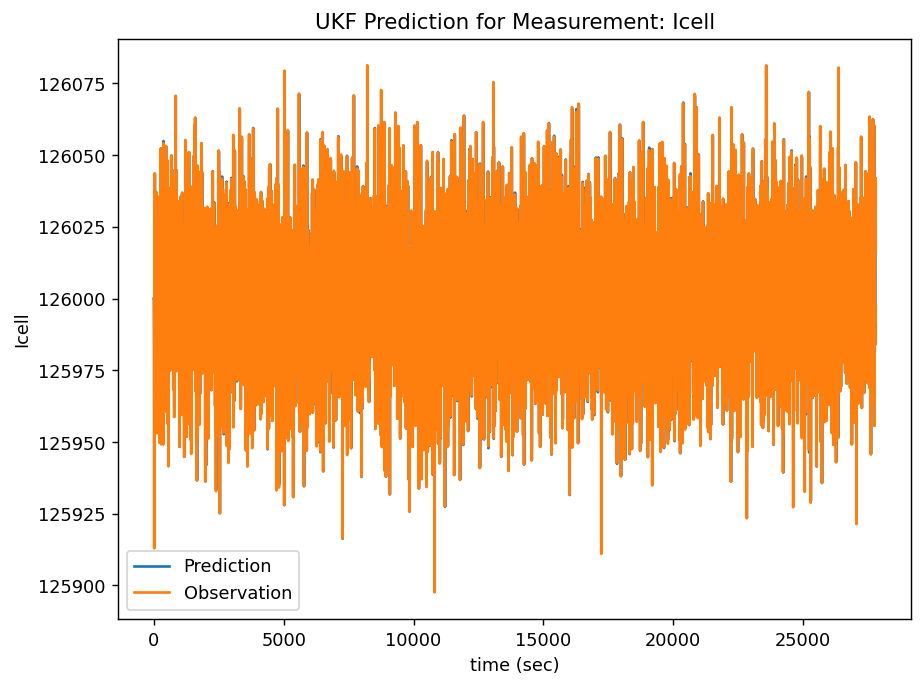

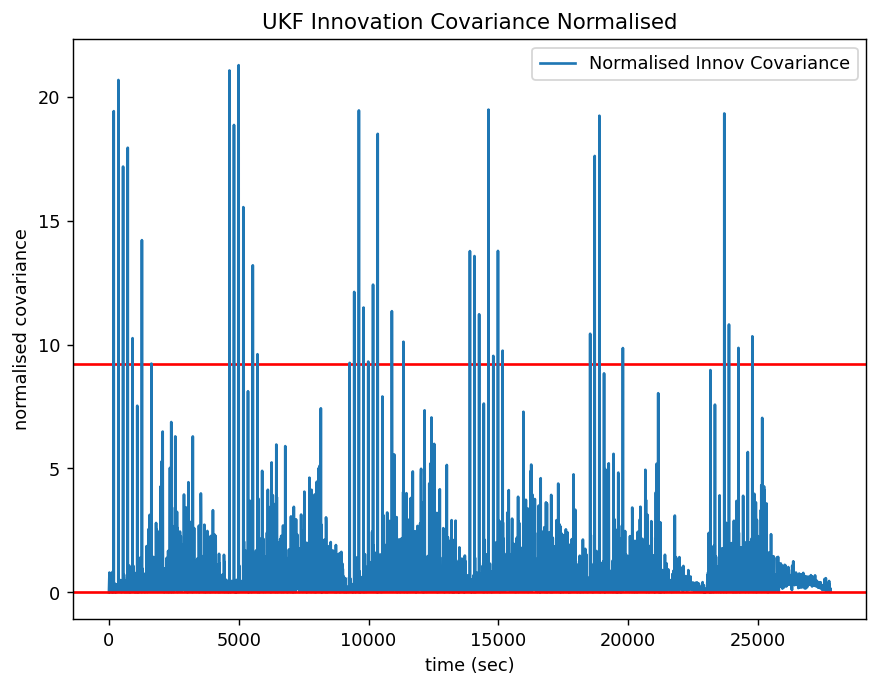

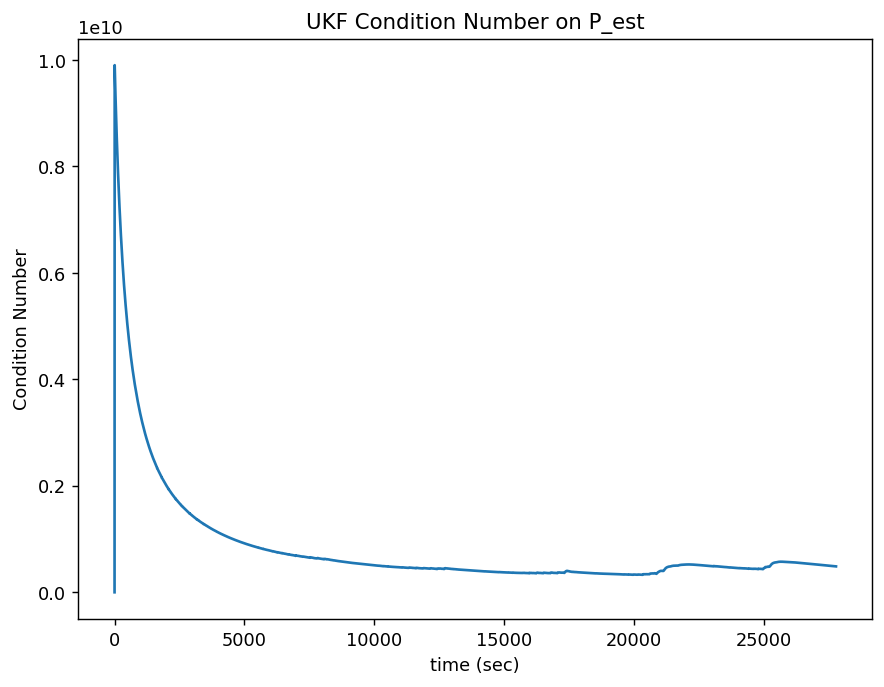

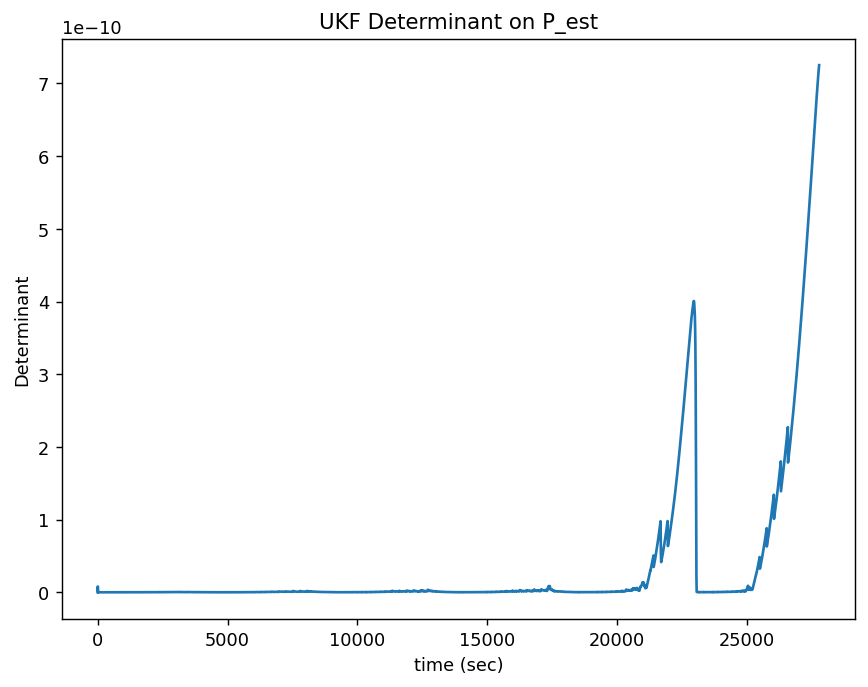

In [44]:
# Run the simulation through the UKF 4 state model 
xest, Pest, xpred, Ppred, innov, innov_cov, cond = ukf_execute(UKF4state, zsim, usim, 5, plotresult=True, xtrue=xsim)